In [3]:
import pandas as pd
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

from gensim import corpora, models
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt


In [4]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


In [5]:
df = pd.read_excel(
    "/Users/pinetree/tactile-design-LDA/123_scopus_export_.xlsx"
)


In [6]:
df["text"] = (
    df["Title"].fillna("") + " " +
    df["Author Keywords"].fillna("") + " " +
    df["Abstract"].fillna("")
)


In [7]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
tokenizer = TreebankWordTokenizer()

custom_stop = {
    "study","paper","result","results","method","methods","analysis","approach",
    "conclusion","implication","implications","introduction","discussion",
    "based","using","use","used","new","one","two","three","within","across",
    "haptic","touch","tactile","design","process","explore","common","user",
    "work","practice","model","product","system","object","support","effect",
    "research","article","publisher","scopus","elsevier",
    "also","may","might","many","much","however","therefore","thus",
    "et", "develop"
}

all_stop = stop_words | custom_stop
stemmed_stop = {stemmer.stem(w) for w in all_stop}

def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    
    cleaned = []
    for t in tokens:
        if t in all_stop:
            continue
        t_stem = stemmer.stem(t)
        if t_stem in stemmed_stop:
            continue
        cleaned.append(t_stem)
    return cleaned


In [8]:
df["tokens"] = df["text"].apply(preprocess_text)

print("문서 수:", len(df))
print("평균 토큰 수:", df["tokens"].apply(len).mean())


문서 수: 123
평균 토큰 수: 109.60162601626017


In [9]:
dictionary = corpora.Dictionary(df["tokens"])
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

print(f"Dictionary size: {len(dictionary)}")


Dictionary size: 498


In [10]:
# 사전에 어떤 단어가 남았는지 확인 (빈도수 상위 50개)
token_counts = {}
for doc in corpus:
    for word_id, count in doc:
        token_counts[word_id] = token_counts.get(word_id, 0) + count

# 단어와 빈도수 매칭해서 보기
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
for word_id, count in sorted_tokens[:30]:
    print(f"{dictionary[word_id]}: {count}")

interact: 150
materi: 128
visual: 108
digit: 82
commun: 69
architectur: 61
student: 59
social: 59
activ: 58
space: 57
provid: 56
tool: 55
technolog: 55
inform: 53
percept: 53
environ: 50
prototyp: 50
understand: 46
cultur: 43
sens: 43
evalu: 42
textil: 42
project: 41
textur: 40
make: 40
engag: 40
differ: 40
innov: 39
educ: 37
gener: 37


In [11]:
num_topics = 7   # ← coherence 결과로 결정

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=20,
    alpha="auto"
)


In [12]:
for i, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {i+1}: {topic}")


Topic 1: 0.055*"visual" + 0.045*"impair" + 0.040*"access" + 0.037*"art" + 0.032*"servic" + 0.030*"public" + 0.030*"cultur" + 0.019*"inclus" + 0.016*"person" + 0.015*"innov"
Topic 2: 0.037*"interact" + 0.020*"commun" + 0.017*"visual" + 0.016*"student" + 0.012*"technolog" + 0.012*"provid" + 0.011*"project" + 0.010*"form" + 0.010*"engag" + 0.009*"educ"
Topic 3: 0.027*"social" + 0.026*"interact" + 0.017*"activ" + 0.014*"interfac" + 0.013*"cultur" + 0.012*"relationship" + 0.011*"inform" + 0.011*"mobil" + 0.010*"environ" + 0.010*"commun"
Topic 4: 0.028*"gestur" + 0.023*"tool" + 0.018*"inform" + 0.016*"spatial" + 0.015*"pattern" + 0.015*"tension" + 0.015*"interact" + 0.015*"collabor" + 0.014*"knowledg" + 0.013*"field"
Topic 5: 0.048*"materi" + 0.029*"textil" + 0.023*"digit" + 0.017*"fashion" + 0.016*"affect" + 0.015*"interact" + 0.014*"percept" + 0.014*"children" + 0.013*"futur" + 0.012*"emot"
Topic 6: 0.034*"architectur" + 0.018*"bodi" + 0.017*"build" + 0.017*"sens" + 0.015*"prototyp" + 0.01

중복포함단어수

In [13]:
all_tokens = [token for doc in df["tokens"] for token in doc]
total_token_count = len(all_tokens)

print(f"중복 포함 단어 수 (Total tokens): {total_token_count}")


중복 포함 단어 수 (Total tokens): 13481


고유단어수

In [14]:
unique_token_count = len(set(all_tokens))

print(f"고유 단어 수 (Unique tokens): {unique_token_count}")


고유 단어 수 (Unique tokens): 2976


문서 평균 단어 수 (논문에 자주 쓰임)

In [15]:
avg_tokens_per_doc = df["tokens"].apply(len).mean()

print(f"문서당 평균 단어 수: {avg_tokens_per_doc:.2f}")


문서당 평균 단어 수: 109.60


(선택) Dictionary 기준 어휘 크기

In [16]:
print(f"LDA Dictionary 단어 수: {len(dictionary)}")


LDA Dictionary 단어 수: 498


In [17]:
coherence_model = CoherenceModel(
    model=lda_model,
    texts=df["tokens"],
    dictionary=dictionary,
    coherence="c_v"
)

coherence_score = coherence_model.get_coherence()
print(f"Coherence (c_v): {coherence_score:.4f}")


Coherence (c_v): 0.2954


토픽 수 결정

In [18]:

def compute_coherence_only(dictionary, corpus, texts, start=2, limit=15, step=1):
    topic_nums = []
    coherence_scores = []

    for k in range(start, limit + 1, step):
        lda = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=20,
            alpha="auto"
        )

        coherence_model = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v"
        )
        coherence = coherence_model.get_coherence()

        topic_nums.append(k)
        coherence_scores.append(coherence)

        print(f"k={k:2d} | Coherence={coherence:.4f}")

    return topic_nums, coherence_scores


In [19]:
topic_nums, coherence_scores = compute_coherence_only(
    dictionary=dictionary,
    corpus=corpus,
    texts=df["tokens"],
    start=2,
    limit=15,
    step=1
)


k= 2 | Coherence=0.2552
k= 3 | Coherence=0.2549
k= 4 | Coherence=0.2742
k= 5 | Coherence=0.2794
k= 6 | Coherence=0.2767
k= 7 | Coherence=0.2954
k= 8 | Coherence=0.2527
k= 9 | Coherence=0.2640
k=10 | Coherence=0.2748
k=11 | Coherence=0.2956
k=12 | Coherence=0.2909
k=13 | Coherence=0.2808
k=14 | Coherence=0.2909
k=15 | Coherence=0.2780


In [20]:

optimal_k = topic_nums[np.argmax(coherence_scores)]
max_coherence = max(coherence_scores)

print(f"최대 Coherence: {max_coherence:.4f} (토픽 수 = {optimal_k})")


최대 Coherence: 0.2956 (토픽 수 = 11)


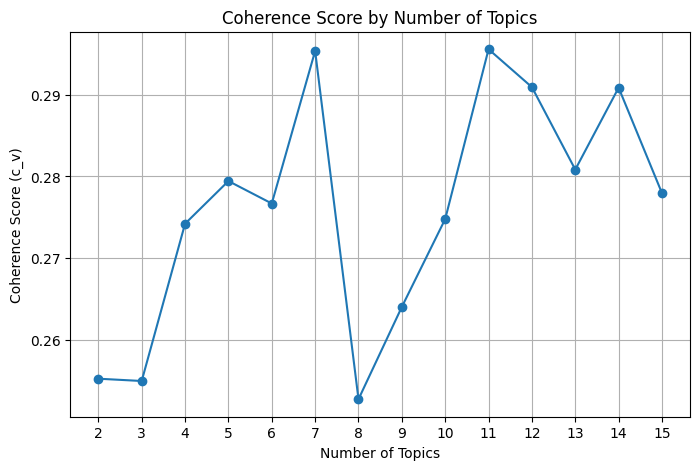

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(topic_nums, coherence_scores, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score by Number of Topics")
plt.xticks(topic_nums)
plt.grid(True)
plt.show()


In [22]:
coherence_df = pd.DataFrame({
    "num_topics": topic_nums,
    "coherence": coherence_scores
})

coherence_df.to_csv(
    "데이터/lda_coherence.csv",
    index=False,
    encoding="utf-8-sig"
)

perplexity 최적값

In [23]:


def compute_perplexity_only(dictionary, corpus, start=2, limit=15, step=1):
    topic_nums = []
    perplexity_scores = []

    for k in range(start, limit + 1, step):
        lda = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=20,
            alpha="auto"
        )

        # gensim은 log perplexity 반환
        log_perplexity = lda.log_perplexity(corpus)
        perplexity = np.exp(-log_perplexity)

        topic_nums.append(k)
        perplexity_scores.append(perplexity)

        print(f"k={k:2d} | Perplexity={perplexity:.2f}")

    return topic_nums, perplexity_scores


In [24]:
topic_nums, perplexity_scores = compute_perplexity_only(
    dictionary=dictionary,
    corpus=corpus,
    start=2,
    limit=15,
    step=1
)


k= 2 | Perplexity=421.20
k= 3 | Perplexity=423.28
k= 4 | Perplexity=430.02
k= 5 | Perplexity=435.50
k= 6 | Perplexity=444.10
k= 7 | Perplexity=457.24
k= 8 | Perplexity=466.51
k= 9 | Perplexity=477.86
k=10 | Perplexity=488.46
k=11 | Perplexity=490.57
k=12 | Perplexity=503.78
k=13 | Perplexity=511.27
k=14 | Perplexity=535.34
k=15 | Perplexity=526.85


In [25]:
optimal_k = topic_nums[np.argmin(perplexity_scores)]
min_perplexity = min(perplexity_scores)

print(f"최소 Perplexity: {min_perplexity:.2f} (토픽 수 = {optimal_k})")


최소 Perplexity: 421.20 (토픽 수 = 2)


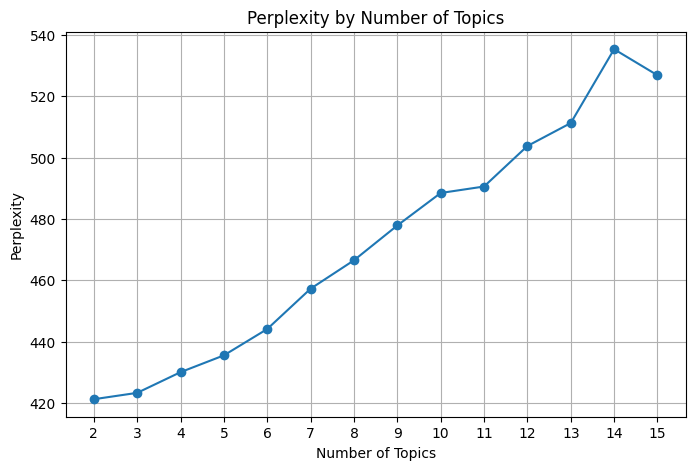

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexity_scores, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity by Number of Topics")
plt.xticks(topic_nums)
plt.grid(True)
plt.show()


In [27]:

perplexity_df = pd.DataFrame({
    "num_topics": topic_nums,
    "perplexity": perplexity_scores
})

perplexity_df.to_csv(
    "데이터/lda_perplexity.csv",
    index=False,
    encoding="utf-8-sig"
)


토픽 내 단어 수 결정

In [92]:


topn = 50

rows = []
for topic_id in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_id, topn=topn)
    for rank, (word, prob) in enumerate(topic_terms, start=1):
        rows.append({
            "topic": f"Topic {topic_id+1}",
            "rank": rank,
            "term": word,
            "probability": prob
        })

topic_terms_df_round = pd.DataFrame(rows).sort_values(["topic","rank"]).reset_index(drop=True)
topic_terms_df_round["cum_prob"] = topic_terms_df_round.groupby("topic")["probability"].cumsum()



In [96]:


def safe_min_rank(x):
    hit = x[x["cum_prob"] >= threshold]
    if hit.empty:
        return x["rank"].max()
    return int(hit.iloc[0]["rank"])

optimal_n = topic_terms_df_round.groupby("topic").apply(safe_min_rank)
optimal_n


topic
Topic 1    30
Topic 2    50
Topic 3    50
Topic 4    50
Topic 5    50
Topic 6    50
Topic 7    50
dtype: int64

In [97]:
topic_terms_df_round.groupby("topic")["cum_prob"].max().sort_values()


topic
Topic 2    0.392725
Topic 3    0.400338
Topic 6    0.424953
Topic 7    0.477659
Topic 5    0.487015
Topic 4    0.493792
Topic 1    0.615975
Name: cum_prob, dtype: float32

In [98]:
topic_terms_df_round["cum_prob"] = (
    topic_terms_df_round
    .groupby("topic")["probability"]
    .cumsum()
)

topic_terms_df_round


,topic,rank,term,probability,cum_prob
0,Topic 1,1,visual,0.055235,0.055235
1,Topic 1,2,impair,0.044873,0.100108
2,Topic 1,3,access,0.040174,0.140282
3,Topic 1,4,art,0.036639,0.176921
4,Topic 1,5,servic,0.031654,0.208575
...,...,...,...,...,...
345,Topic 7,46,without,0.005170,0.457303
346,Topic 7,47,student,0.005167,0.462470
347,Topic 7,48,specif,0.005139,0.467609
348,Topic 7,49,context,0.005027,0.472636


In [99]:
topic_terms_df_round["cum_prob"] = (
    topic_terms_df_round
        .groupby("topic")["probability"]
        .cumsum()
)

topic_terms_df_round


,topic,rank,term,probability,cum_prob
0,Topic 1,1,visual,0.055235,0.055235
1,Topic 1,2,impair,0.044873,0.100108
2,Topic 1,3,access,0.040174,0.140282
3,Topic 1,4,art,0.036639,0.176921
4,Topic 1,5,servic,0.031654,0.208575
...,...,...,...,...,...
345,Topic 7,46,without,0.005170,0.457303
346,Topic 7,47,student,0.005167,0.462470
347,Topic 7,48,specif,0.005139,0.467609
348,Topic 7,49,context,0.005027,0.472636


시각화

In [100]:

num_topics = 7   # coherence로 결정한 값

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=20,
    alpha="auto"
)


In [29]:

print(lda_model)


LdaModel<num_terms=498, num_topics=7, decay=0.5, chunksize=2000>


In [30]:
pip install "pandas==1.5.3"


Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd, pyLDAvis
print("pandas:", pd.__version__)
print("pyLDAvis:", pyLDAvis.__version__)


pandas: 1.5.3
pyLDAvis: 3.4.0


In [32]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display

vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

pyLDAvis.enable_notebook()
display(vis_data)



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.237749  0.036640       1        1   6.727736
1     -0.007912 -0.026340       2        1  22.768196
2     -0.002975 -0.090798       3        1  17.095644
3      0.076186  0.195894       4        1  10.852460
4      0.056415 -0.054219       5        1  16.211187
5      0.022450 -0.029413       6        1  16.184735
6      0.093584 -0.031764       7        1  10.160042, topic_info=            Term        Freq       Total Category  logprob  loglift
28        visual  100.000000  100.000000  Default  30.0000  30.0000
206       materi  120.000000  120.000000  Default  29.0000  29.0000
134       impair   24.000000   24.000000  Default  28.0000  28.0000
121       access   31.000000   31.000000  Default  27.0000  27.0000
354  architectur   59.000000   59.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
347         valu    5.509739   24.369407   Topic7  -4.9805   0.7999
288       applic    5.596749   31.433025   Topic7  -4.9648   0.5610
397     interfac    5.656674   35.159234   Topic7  -4.9542   0.4597
200         form    5.563251   35.124613   Topic7  -4.9708   0.4440
51       percept    5.650206   50.809648   Topic7  -4.9553   0.0903

[386 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.115041  abstract
0         3  0.115041  abstract
0         6  0.690247  abstract
121       1  0.665325    access
121       2  0.095046    access
...     ...       ...       ...
222       6  0.420929     world
427       5  0.361530     would
427       7  0.602550     would
362       4  0.231893       yet
362       6  0.695679       yet

[1049 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

🔹 (A) 토픽별 상위 단어 Bar Chart

“각 토픽을 구성하는 핵심 단어는 무엇인가”

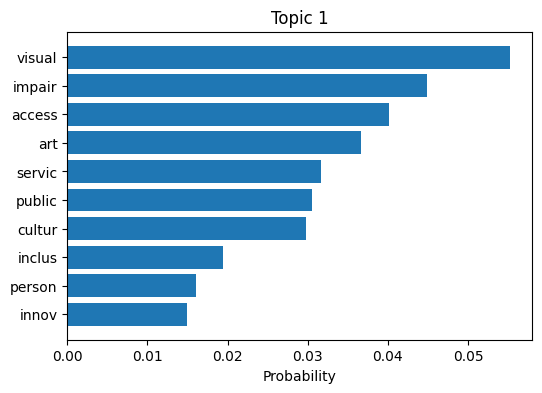

In [33]:
import matplotlib.pyplot as plt

def plot_top_words(lda_model, dictionary, topic_id, topn=10):
    words_probs = lda_model.show_topic(topic_id, topn=topn)
    words, probs = zip(*words_probs)

    plt.figure(figsize=(6,4))
    plt.barh(words, probs)
    plt.gca().invert_yaxis()
    plt.title(f"Topic {topic_id+1}")
    plt.xlabel("Probability")
    plt.show()

# 예시
plot_top_words(lda_model, dictionary, topic_id=0)


🔹 (B) 모든 토픽 한 번에 (Subplot)

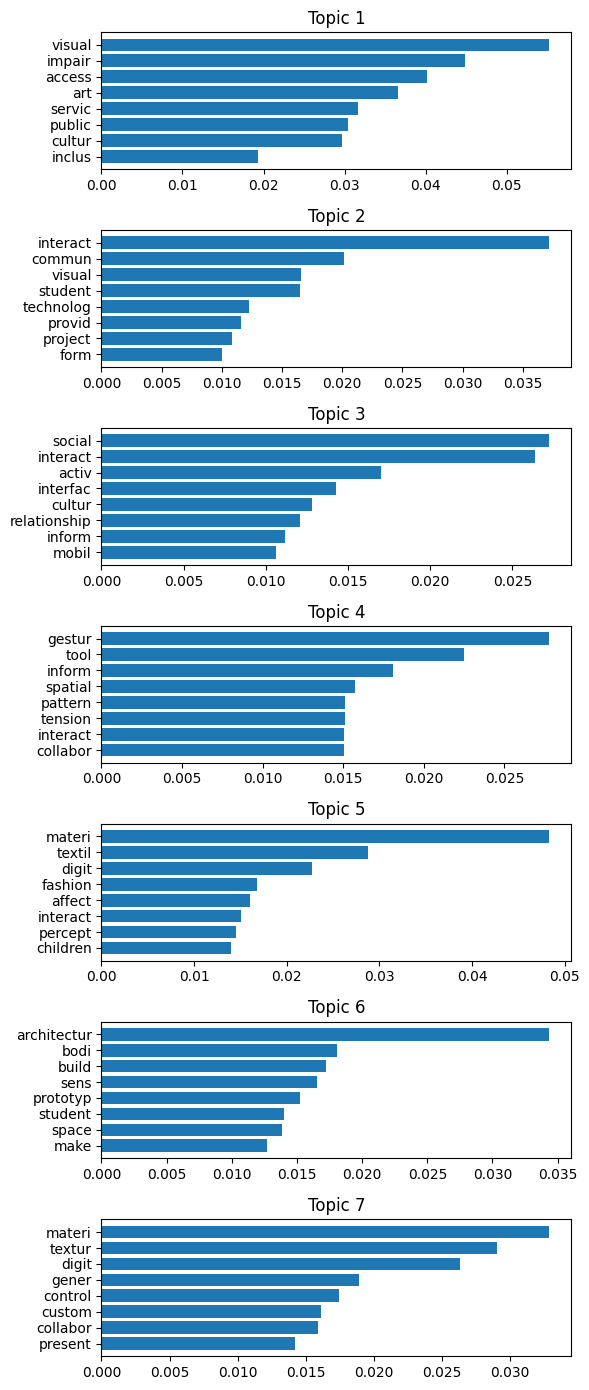

In [34]:
fig, axes = plt.subplots(lda_model.num_topics, 1, figsize=(6, 2*lda_model.num_topics))

for i, ax in enumerate(axes):
    words_probs = lda_model.show_topic(i, topn=8)
    words, probs = zip(*words_probs)
    ax.barh(words, probs)
    ax.set_title(f"Topic {i+1}")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [101]:


topn = 10  # 토픽별 상위 단어 수

rows = []

for topic_id in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_id, topn=topn)
    for rank, (word, prob) in enumerate(topic_terms, start=1):
        rows.append({
            "topic": f"Topic {topic_id+1}",
            "rank": rank,
            "term": word,
            "probability": prob
        })

topic_terms_df = pd.DataFrame(rows)

# 보기 좋게 정렬
topic_terms_df = topic_terms_df.sort_values(
    ["topic", "rank"]
).reset_index(drop=True)

topic_terms_df


,topic,rank,term,probability
0,Topic 1,1,visual,0.055235
1,Topic 1,2,impair,0.044873
2,Topic 1,3,access,0.040174
3,Topic 1,4,art,0.036639
4,Topic 1,5,servic,0.031654
...,...,...,...,...
65,Topic 7,6,custom,0.016115
66,Topic 7,7,collabor,0.015942
67,Topic 7,8,present,0.014241
68,Topic 7,9,cognit,0.012287


In [102]:
topic_terms_df_round = topic_terms_df.copy()
topic_terms_df_round["probability"] = topic_terms_df_round["probability"].round(4)
topic_terms_df_round


,topic,rank,term,probability
0,Topic 1,1,visual,0.0552
1,Topic 1,2,impair,0.0449
2,Topic 1,3,access,0.0402
3,Topic 1,4,art,0.0366
4,Topic 1,5,servic,0.0317
...,...,...,...,...
65,Topic 7,6,custom,0.0161
66,Topic 7,7,collabor,0.0159
67,Topic 7,8,present,0.0142
68,Topic 7,9,cognit,0.0123


In [103]:
topic_terms_df_round.to_csv(
    "데이터/topic_top_terms_by_priority.csv",
    index=False,
    encoding="utf-8-sig"
)


In [104]:
topic_terms_df_round["cum_prob"] = (
    topic_terms_df_round
    .groupby("topic")["probability"]
    .cumsum()
)

topic_terms_df_round


,topic,rank,term,probability,cum_prob
0,Topic 1,1,visual,0.0552,0.0552
1,Topic 1,2,impair,0.0449,0.1001
2,Topic 1,3,access,0.0402,0.1403
3,Topic 1,4,art,0.0366,0.1769
4,Topic 1,5,servic,0.0317,0.2086
...,...,...,...,...,...
65,Topic 7,6,custom,0.0161,0.1409
66,Topic 7,7,collabor,0.0159,0.1568
67,Topic 7,8,present,0.0142,0.1710
68,Topic 7,9,cognit,0.0123,0.1833


In [35]:


doc_topics = [
    [prob for _, prob in lda_model.get_document_topics(bow, minimum_probability=0)]
    for bow in corpus
]

doc_topic_df = pd.DataFrame(doc_topics)

doc_topic_df.head()


,0,1,2,3,4,5,6
0,0.000895,0.992610,0.001276,0.001287,0.001418,0.001476,0.001037
1,0.000489,0.001096,0.000697,0.995569,0.000775,0.000806,0.000567
2,0.000228,0.000512,0.000326,0.000328,0.997964,0.000377,0.000265
3,0.996447,0.000838,0.000533,0.000538,0.000593,0.000617,0.000434
4,0.000314,0.000704,0.000448,0.000452,0.000498,0.000518,0.997065


2️⃣ 문서–토픽 관계 시각화 (해석용으로 매우 중요)
🔹 (C) 문서별 주요 토픽 분포 (Stacked Bar)

“문서들은 어떤 토픽 조합으로 구성되는가”

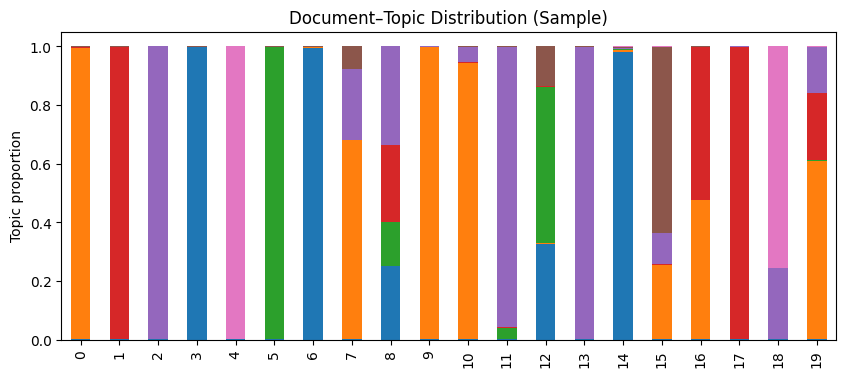

In [36]:
doc_topic_df.iloc[:20].plot(
    kind="bar",
    stacked=True,
    figsize=(10,4),
    legend=False
)
plt.ylabel("Topic proportion")
plt.title("Document–Topic Distribution (Sample)")
plt.show()


🔹 (D) 각 토픽이 차지하는 평균 비중

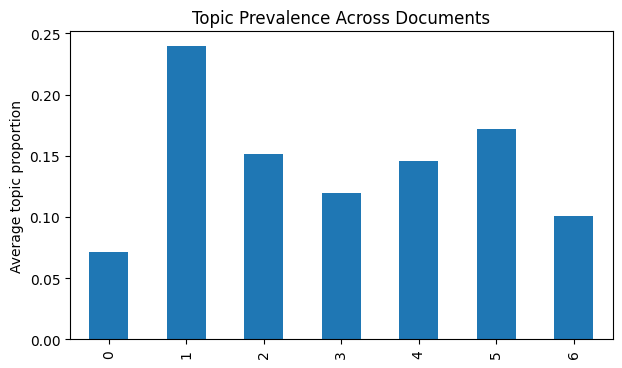

In [37]:
topic_prevalence = doc_topic_df.mean()

topic_prevalence.plot(
    kind="bar",
    figsize=(7,4)
)
plt.ylabel("Average topic proportion")
plt.title("Topic Prevalence Across Documents")
plt.show()


3️⃣ 토픽 간 유사도 / 구조 시각화 (고급)
🔹 (E) 토픽 간 코사인 유사도 Heatmap

“토픽들이 서로 얼마나 겹치는가”

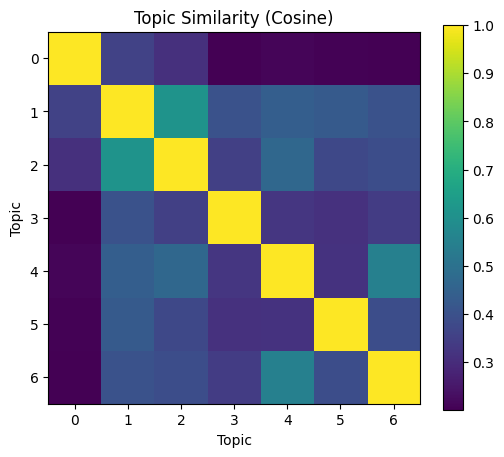

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

topic_word_matrix = lda_model.get_topics()
similarity = cosine_similarity(topic_word_matrix)

plt.figure(figsize=(6,5))
plt.imshow(similarity, cmap="viridis")
plt.colorbar()
plt.title("Topic Similarity (Cosine)")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


🔹 (F) PCA / t-SNE로 토픽 위치 시각화

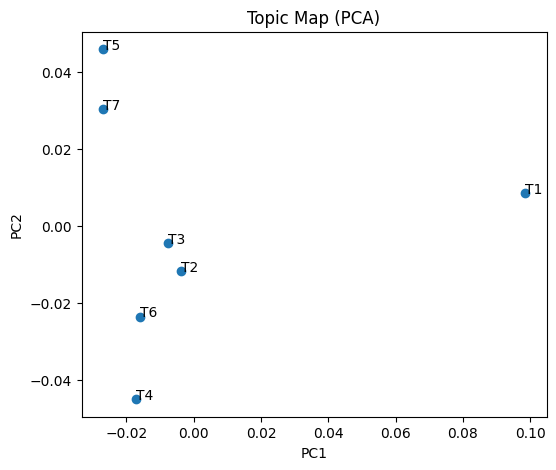

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coords = pca.fit_transform(topic_word_matrix)

plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1])

for i in range(len(coords)):
    plt.text(coords[i,0], coords[i,1], f"T{i+1}")

plt.title("Topic Map (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


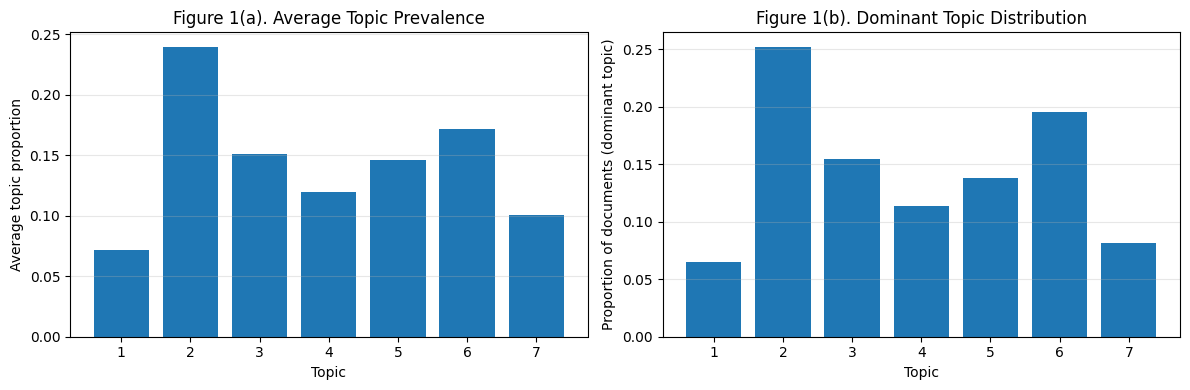

,topic,avg_prevalence,dominant_doc_count,dominant_doc_ratio
0,Topic 1,0.071506,8,0.065041
1,Topic 2,0.239719,31,0.252033
2,Topic 3,0.151286,19,0.154472
3,Topic 4,0.119328,14,0.113821
4,Topic 5,0.145727,17,0.138211
5,Topic 6,0.171690,24,0.195122
6,Topic 7,0.100744,10,0.081301


In [40]:

import matplotlib.pyplot as plt

# =========================================================
# Figure 1(a) Average Topic Prevalence
#  + Figure 1(b) Dominant Topic Distribution
# =========================================================

K = lda_model.num_topics

# 1) 문서-토픽 분포 행렬 만들기 (N_docs x K)
doc_topic = np.zeros((len(corpus), K), dtype=float)
for i, bow in enumerate(corpus):
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        doc_topic[i, tid] = prob

doc_topic_df = pd.DataFrame(
    doc_topic,
    columns=[f"Topic {i+1}" for i in range(K)]
)

# 2) (a) 평균 토픽 비중
avg_prevalence = doc_topic_df.mean(axis=0).values  # 길이 K

# 3) (b) 지배적 토픽(각 문서에서 가장 큰 토픽) 빈도/비율
dominant_topic_idx = doc_topic_df.values.argmax(axis=1)  # 0..K-1
dominant_counts = pd.Series(dominant_topic_idx).value_counts().sort_index()
dominant_counts = dominant_counts.reindex(range(K), fill_value=0)

dominant_ratio = dominant_counts / len(corpus)

# 4) Figure 1(a)+(b) 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ---- (a) Average Topic Prevalence ----
axes[0].bar(range(1, K+1), avg_prevalence)
axes[0].set_title("Figure 1(a). Average Topic Prevalence")
axes[0].set_xlabel("Topic")
axes[0].set_ylabel("Average topic proportion")
axes[0].set_xticks(range(1, K+1))
axes[0].grid(True, axis="y", alpha=0.3)

# ---- (b) Dominant Topic Distribution ----
axes[1].bar(range(1, K+1), dominant_ratio.values)
axes[1].set_title("Figure 1(b). Dominant Topic Distribution")
axes[1].set_xlabel("Topic")
axes[1].set_ylabel("Proportion of documents (dominant topic)")
axes[1].set_xticks(range(1, K+1))
axes[1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# 5) (선택) 표로 저장 (논문 표/부록/검증용)
out_df = pd.DataFrame({
    "topic": [f"Topic {i+1}" for i in range(K)],
    "avg_prevalence": avg_prevalence,
    "dominant_doc_count": dominant_counts.values,
    "dominant_doc_ratio": dominant_ratio.values
})

out_df


A) 토픽별 비중 변화: 연도별 Topic Prevalence Over Time
1) 연도 컬럼 자동 탐색 + 정리

Scopus 엑셀은 보통 Year, Publication Year, Year Published 같은 이름이 많아서 자동으로 찾아 씁니다.

In [41]:

# 1) 연도 컬럼 찾기 (가능한 후보들)
year_candidates = [
    "Year", "Publication Year", "Year Published", "PubYear", "PY", "출판연도", "연도"
]

year_col = None
for c in year_candidates:
    if c in df.columns:
        year_col = c
        break

if year_col is None:
    raise ValueError(f"연도 컬럼을 못 찾았어요. df.columns에서 연도 컬럼명을 확인해 주세요.\n{list(df.columns)}")

print("연도 컬럼:", year_col)

# 2) 연도 정수화
years = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")


연도 컬럼: Year


In [68]:
[c for c in df.columns if "year" in c.lower() or "date" in c.lower()]


['Year']

In [63]:

# ✅ 문서(행) 수와 동일한 길이로 years 생성
years = pd.to_numeric(df[year_col], errors="coerce")

print("문서 수:", len(df), " / years 길이:", len(years))
years.head()


문서 수: 123  / years 길이: 123


0    2025
1    2025
2    2025
3    2025
4    2025
Name: Year, dtype: int64

In [64]:
years.value_counts().sort_index()


1984     1
1999     1
2005     2
2006     2
2007     1
2008     1
2010     5
2011     2
2012     2
2013     6
2014     8
2015     2
2016     6
2017    16
2018     4
2019    12
2020     6
2021     9
2022     5
2023    11
2024     7
2025    14
Name: Year, dtype: int64

2) 연도별 평균 토픽 비중 계산 + 라인 플롯

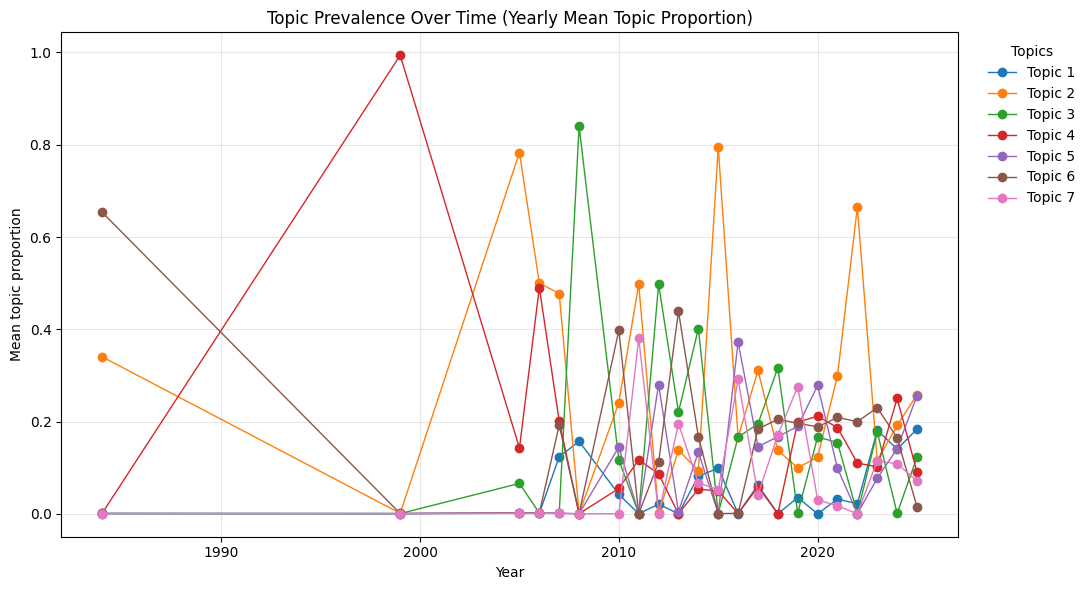

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
year,,,,,,,
1984,0.000808,0.340713,0.001152,0.001162,0.001281,0.653945,0.000937
1999,0.000664,0.001488,0.000946,0.993985,0.001052,0.001095,0.000770
2005,0.001411,0.783235,0.066245,0.142911,0.002236,0.002327,0.001635
2006,0.001337,0.500391,0.001906,0.490492,0.002119,0.002205,0.001550
2007,0.124070,0.477528,0.001624,0.201055,0.001805,0.192598,0.001320


In [65]:
# =========================================================
# 연도별 토픽 비중 (Topic Prevalence Over Time)
# - 컬러–토픽 대응 명확
# - 정확한 수치(yearly) 확인 가능
# =========================================================

# 1) doc_topic_df와 연도 결합
dt = doc_topic_df.copy()
dt["year"] = years

# 2) 결측 연도 제거 + 정수형 변환
dt = dt.dropna(subset=["year"])
dt["year"] = dt["year"].astype(int)

# 3) 연도별 평균 토픽 비중 계산
yearly = (
    dt.groupby("year")[doc_topic_df.columns]
    .mean()
    .sort_index()
)

# 4) 시각화
plt.figure(figsize=(11, 6))

for col in yearly.columns:
    plt.plot(
        yearly.index,
        yearly[col],
        marker="o",
        linewidth=1,
        label=col     # ✅ 컬러–토픽 대응 핵심
    )

plt.title("Topic Prevalence Over Time (Yearly Mean Topic Proportion)")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.grid(True, alpha=0.3)

# ✅ 범례 추가 (논문용 정석 위치)
plt.legend(
    title="Topics",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.show()

# 5) 정확한 데이터값 확인
yearly.head()


📌 논문에선 보통 상위 N개 토픽만 보여주는 게 더 깔끔합니다. (예: 평균 비중 상위 4개)

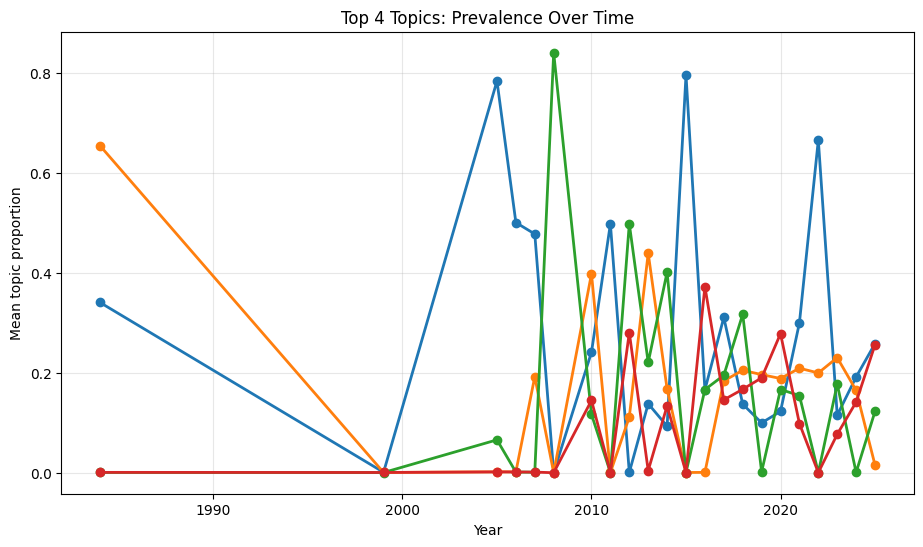

['Topic 2', 'Topic 6', 'Topic 3', 'Topic 5']

In [66]:

topN = 4
top_topics = doc_topic_df.mean().sort_values(ascending=False).head(topN).index

plt.figure(figsize=(11, 6))
for col in top_topics:
    plt.plot(yearly.index, yearly[col], marker="o", linewidth=2)

plt.title(f"Top {topN} Topics: Prevalence Over Time")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.grid(True, alpha=0.3)
plt.show()

top_topics.tolist()


B) “주기적 상승/하락 패턴” 정량화

연도 데이터는 보통 계절성(12개월)은 없지만, “주기성(몇 년 단위 등)” 주장은 가능해요. 논문/리뷰 대응에 가장 무난한 조합은:

이동평균(스무딩)으로 추세 vs 변동 분리

ACF(자기상관)으로 주기 후보(몇 년 단위) 제시

1) 이동평균(rolling mean)

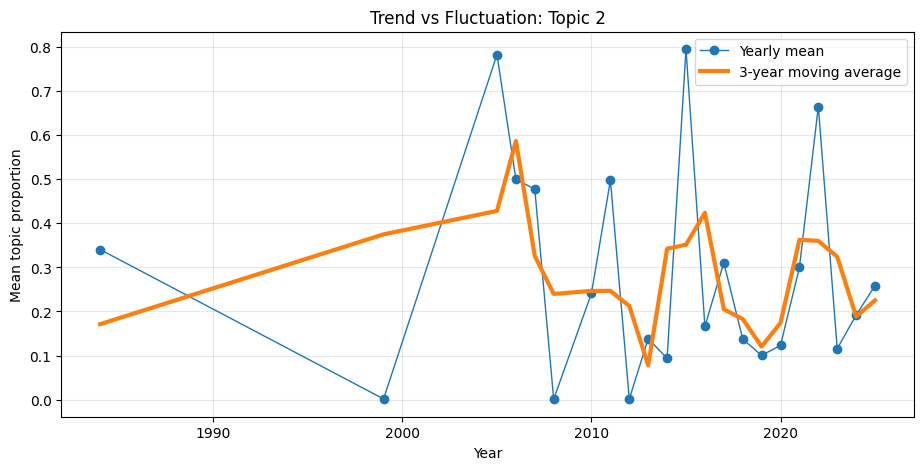

In [67]:

topic_to_check = top_topics[0]  # 가장 큰 토픽 하나부터 체크 (원하면 바꿔도 됨)

series = yearly[topic_to_check].copy()
roll = series.rolling(window=3, center=True, min_periods=1).mean()  # 3년 이동평균

plt.figure(figsize=(11, 5))
plt.plot(series.index, series.values, marker="o", linewidth=1, label="Yearly mean")
plt.plot(roll.index, roll.values, linewidth=3, label="3-year moving average")
plt.title(f"Trend vs Fluctuation: {topic_to_check}")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


2) ACF(자기상관) — “몇 년 주기” 힌트
📌 해석 포인트(논문용):

Lag 2~5에서 양의 상관이 반복되면 “몇 년 단위의 반복적 변동 가능성”을 탐색적으로 제시할 수 있어요.

단, 표본연도 수가 적으면(예: 10년 이하) 강한 주장 금지하고 “exploratory”로 쓰는 게 안전합니다.

/var/folders/dw/s7gyvbt14193__4lgngl_yr80000gn/T/ipykernel_73308/3901874424.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)
/var/folders/dw/s7gyvbt14193__4lgngl_yr80000gn/T/ipykernel_73308/3901874424.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)


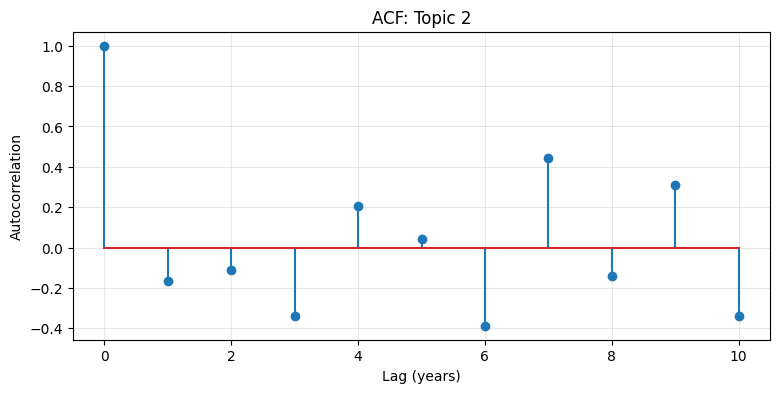

In [70]:

def plot_acf_manual(x, max_lag=10, title="ACF"):
    x = np.asarray(x, dtype=float)
    x = x - np.nanmean(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < 3:
        raise ValueError("ACF를 계산하기엔 연도 데이터 포인트가 너무 적어요.")

    acf_vals = []
    for lag in range(max_lag + 1):
        if lag == 0:
            acf_vals.append(1.0)
        else:
            acf_vals.append(np.corrcoef(x[:-lag], x[lag:])[0, 1])

    plt.figure(figsize=(9, 4))
    plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)
    plt.title(title)
    plt.xlabel("Lag (years)")
    plt.ylabel("Autocorrelation")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_acf_manual(series.values, max_lag=10, title=f"ACF: {topic_to_check}")


C) 토픽 간 유사도 매트릭스 (Topic Similarity Matrix)

가장 보편적이고 리뷰어 설득에 바로 먹힙니다.

1) 토픽-단어 분포 행렬 기반 코사인 유사도

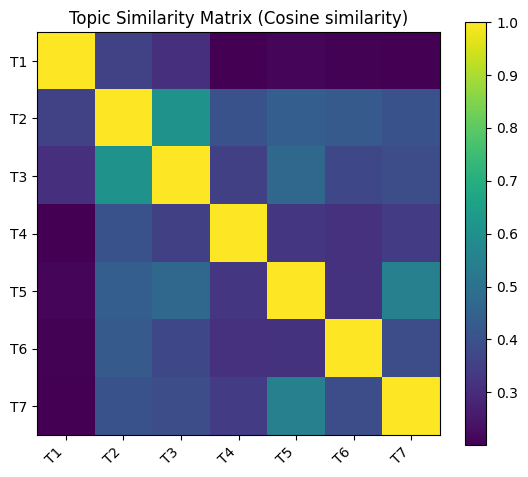

,T1,T2,T3,T4,T5,T6,T7
T1,1.000,0.359,0.312,0.202,0.211,0.206,0.200
T2,0.359,1.000,0.610,0.401,0.438,0.427,0.403
T3,0.312,0.610,1.000,0.350,0.467,0.373,0.388
T4,0.202,0.401,0.350,1.000,0.327,0.314,0.343
T5,0.211,0.438,0.467,0.327,1.000,0.317,0.549


In [71]:


topic_word = lda_model.get_topics()   # (K x V) 토픽-단어 확률행렬
sim = cosine_similarity(topic_word)  # (K x K)

plt.figure(figsize=(6.5, 5.5))
plt.imshow(sim)
plt.colorbar()
plt.title("Topic Similarity Matrix (Cosine similarity)")
plt.xticks(range(K), [f"T{i+1}" for i in range(K)], rotation=45, ha="right")
plt.yticks(range(K), [f"T{i+1}" for i in range(K)])
plt.grid(False)
plt.show()

sim_df = pd.DataFrame(sim, index=[f"T{i+1}" for i in range(K)], columns=[f"T{i+1}" for i in range(K)])
sim_df.round(3).head()


1️⃣ 토픽별 연도 변화 기울기(slope) 계산

단순선형회귀: topic_prevalence=β0​+β1​⋅year

In [72]:

years = yearly.index.values.astype(float)

slope_rows = []

for topic in yearly.columns:
    y = yearly[topic].values.astype(float)

    # 결측 제거
    mask = ~np.isnan(y)
    x = years[mask]
    y = y[mask]

    if len(x) < 3:
        slope = np.nan
        r2 = np.nan
    else:
        # 1차 회귀
        coef = np.polyfit(x, y, 1)
        slope = coef[0]

        # R^2 계산 (설명력 보조 지표)
        y_hat = np.polyval(coef, x)
        ss_res = np.sum((y - y_hat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    slope_rows.append({
        "topic": topic,
        "slope": slope,
        "r2": r2
    })

slope_df = pd.DataFrame(slope_rows)
slope_df


,topic,slope,r2
0,Topic 1,0.002604,0.145111
1,Topic 2,-0.002549,0.009963
2,Topic 3,0.001518,0.004781
3,Topic 4,-0.005473,0.055690
4,Topic 5,0.005782,0.224286
5,Topic 6,-0.005198,0.085431
6,Topic 7,0.003315,0.078590


In [73]:

slope_df_sorted = slope_df.sort_values("slope", ascending=False)
slope_df_sorted


,topic,slope,r2
4,Topic 5,0.005782,0.224286
6,Topic 7,0.003315,0.078590
0,Topic 1,0.002604,0.145111
2,Topic 3,0.001518,0.004781
1,Topic 2,-0.002549,0.009963
5,Topic 6,-0.005198,0.085431
3,Topic 4,-0.005473,0.055690


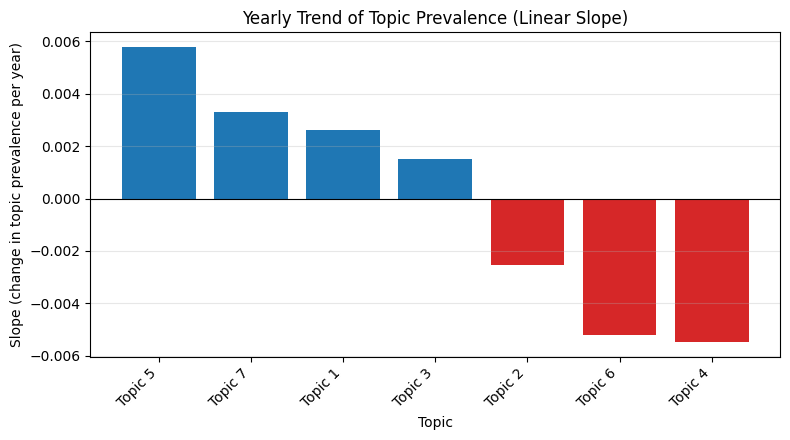

In [74]:

plt.figure(figsize=(8, 4.5))

colors = ["#1f77b4" if s > 0 else "#d62728" for s in slope_df_sorted["slope"]]

plt.bar(
    slope_df_sorted["topic"],
    slope_df_sorted["slope"],
    color=colors
)

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Slope (change in topic prevalence per year)")
plt.xlabel("Topic")
plt.title("Yearly Trend of Topic Prevalence (Linear Slope)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [50]:

slope_df_sorted["slope_z"] = (
    (slope_df_sorted["slope"] - slope_df_sorted["slope"].mean())
    / slope_df_sorted["slope"].std()
)

slope_df_sorted


,topic,slope,r2,slope_z
4,Topic 5,0.005782,0.224286,1.309601
6,Topic 7,0.003315,0.078590,0.750776
0,Topic 1,0.002604,0.145111,0.589809
2,Topic 3,0.001518,0.004781,0.343706
1,Topic 2,-0.002549,0.009963,-0.577223
5,Topic 6,-0.005198,0.085431,-1.177169
3,Topic 4,-0.005473,0.055690,-1.239499


In [54]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 6.3 MB/s eta 0:00:00a 0:00:01


In [55]:

import statsmodels.api as sm

years = yearly.index.values.astype(float)

rows = []

for topic in yearly.columns:
    y = yearly[topic].values.astype(float)

    # 결측 제거
    mask = ~np.isnan(y)
    x = years[mask]
    y = y[mask]

    if len(x) < 3:
        rows.append({
            "topic": topic,
            "slope": np.nan,
            "p_value": np.nan,
            "r2": np.nan,
            "n_years": len(x)
        })
        continue

    X = sm.add_constant(x)  # [1, year]
    model = sm.OLS(y, X).fit()

    rows.append({
        "topic": topic,
        "slope": model.params[1],          # β1
        "p_value": model.pvalues[1],       # p-value for slope
        "r2": model.rsquared,              # R²
        "n_years": int(model.nobs)
    })

reg_df = pd.DataFrame(rows)
reg_df


,topic,slope,p_value,r2,n_years
0,Topic 1,0.002604,0.080276,0.145111,22
1,Topic 2,-0.002549,0.658528,0.009963,22
2,Topic 3,0.001518,0.759792,0.004781,22
3,Topic 4,-0.005473,0.290380,0.055690,22
4,Topic 5,0.005782,0.025989,0.224286,22
5,Topic 6,-0.005198,0.186847,0.085431,22
6,Topic 7,0.003315,0.206347,0.078590,22


In [58]:

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

# 1) 토픽-단어 분포
topic_word = lda_model.get_topics()   # (K x V)

# 2) 코사인 유사도 → 거리
sim = cosine_similarity(topic_word)
dist = 1 - sim

# 3) MDS로 2차원 배치
mds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    random_state=42
)
coords = mds.fit_transform(dist)

coords_df = pd.DataFrame(
    coords,
    columns=["x_struct", "y_struct"]
)
coords_df["topic"] = [f"Topic {i+1}" for i in range(K)]

coords_df


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


,x_struct,y_struct,topic
0,-0.196273,-0.548691,Topic 1
1,0.144588,0.033528,Topic 2
2,-0.016107,-0.144555,Topic 3
3,0.467425,-0.172505,Topic 4
4,-0.381815,0.068199,Topic 5
5,0.231440,0.422942,Topic 6
6,-0.249257,0.341082,Topic 7


In [59]:

plot_df = coords_df.merge(reg_df, on="topic", how="left")
plot_df


,x_struct,y_struct,topic,slope,p_value,r2,n_years
0,-0.196273,-0.548691,Topic 1,0.002604,0.080276,0.145111,22
1,0.144588,0.033528,Topic 2,-0.002549,0.658528,0.009963,22
2,-0.016107,-0.144555,Topic 3,0.001518,0.759792,0.004781,22
3,0.467425,-0.172505,Topic 4,-0.005473,0.290380,0.055690,22
4,-0.381815,0.068199,Topic 5,0.005782,0.025989,0.224286,22
5,0.231440,0.422942,Topic 6,-0.005198,0.186847,0.085431,22
6,-0.249257,0.341082,Topic 7,0.003315,0.206347,0.078590,22


Slope vs Similarity 2D 맵 그리기 (논문용 Figure)

① 증가/감소의 방향성

X축 기준으로 토픽이 증가군 / 감소군으로 명확히 분리됨

② 구조적 군집

Y축에서 가까운 토픽들은 유사한 단어 분포

“증가하는 토픽이 특정 구조 영역에 집중되는지” 논의 가능

③ 의미 있는 변화만 강조

p < .05 토픽 → 진하게 표시

비유의 토픽 → 반투명 처리

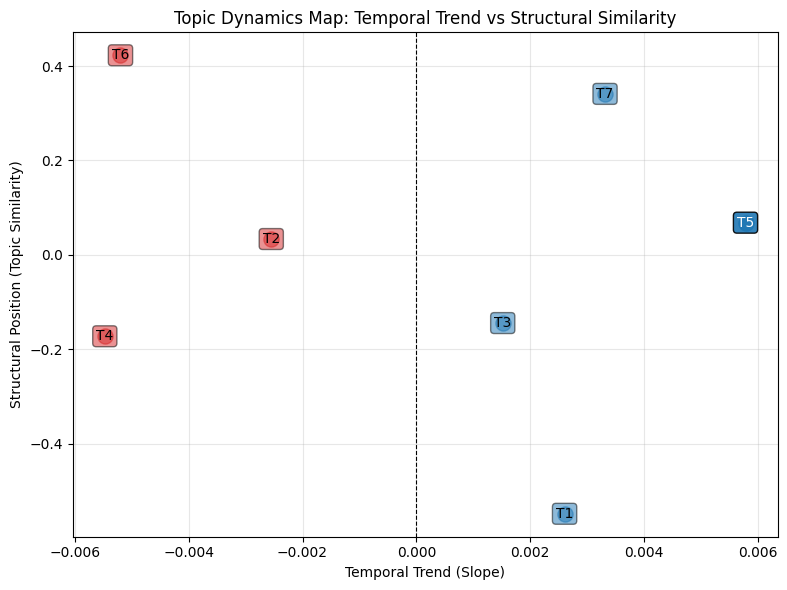

In [60]:

plt.figure(figsize=(8, 6))

for _, row in plot_df.iterrows():
    color = "#1f77b4" if row["slope"] > 0 else "#d62728"
    alpha = 0.9 if row["p_value"] < 0.05 else 0.5  # 유의한 토픽 강조

    plt.scatter(
        row["slope"],
        row["y_struct"],
        color=color,
        s=120,
        alpha=alpha
    )

    plt.text(
        row["slope"],
        row["y_struct"],
        row["topic"].replace("Topic ", "T"),
        fontsize=10,
        ha="center",
        va="center",
        color="white" if alpha > 0.7 else "black",
        bbox=dict(boxstyle="round,pad=0.25", fc=color, alpha=alpha)
    )

plt.axvline(0, color="black", linestyle="--", linewidth=0.8)

plt.xlabel("Temporal Trend (Slope)")
plt.ylabel("Structural Position (Topic Similarity)")
plt.title("Topic Dynamics Map: Temporal Trend vs Structural Similarity")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
